In [3]:
import os
import matplotlib.pyplot as plt
import numpy as np

# import TimeTag
import Visibility_OTPS as visnew
from tqdm import tqdm
from scipy.signal import find_peaks
from scipy.fft import fft, ifft
from scipy.optimize import curve_fit





In [4]:
ch_det = 2 # Channel for single photon detector
ch_AWG = 0 # Channel for AWG trigger
ch_piezo = 3 # Channel for piezo trigger

t_integration = 5 # Integration time for measurement

In [80]:
# 3.8 photons per AWG, early amp oscillation, NKT laser

# folder = 'c:\\Users\\LocalAdmin\\Imperial College London\\UQOG Quantum Memories - PH - General\\Data\\2024-03\\2024-03-14_TimeBinQubit\\'
# filename = folder + os.sep + '2024-03-14_114008.ttbin'
# timetag = 114008

In [42]:
# 3.3 photons per AWG, early amp oscillation, NKT laser

# folder = 'c:\\Users\\LocalAdmin\\Imperial College London\\UQOG Quantum Memories - PH - General\\Data\\2024-03\\2024-03-18_TimeBinQubit\\'
# filename = folder + os.sep + '2024-03-18_130724.ttbin'
timetag = 130724

In [81]:
# 3.1 photons per AWG, santec on 1550 nm

# folder = 'c:\\Users\\LocalAdmin\\Imperial College London\\UQOG Quantum Memories - PH - General\\Data\\2024-03\\2024-03-15_TimeBinQubit\\'
# filename = folder + os.sep + '2024-03-15_143253.ttbin'
# timetag = 143253

In [31]:
# 4.3 photons per AWG

# folder = 'c:\\Users\\LocalAdmin\\Imperial College London\\UQOG Quantum Memories - PH - General\\Data\\2024-03\\2024-03-13_TimeBinQubit\\'
# filename = folder + os.sep + '2024-03-13_164952.ttbin'
# timetag = 164952

In [43]:
# channels, timestamps = TimeTag.load_tt_data(filename)

# Save data
# np.save(f'Data/channels_{timetag}', channels)
# np.save(f'Data/timestamps_{timetag}', timestamps)

# Load data
channels = np.load(f'Data/channels_{timetag}.npy')
timestamps = np.load(f'Data/timestamps_{timetag}.npy')


In [44]:
print(channels)
print(timestamps)

[2. 2. 0. ... 0. 2. 2.]
[1.29303862e+12 1.29303885e+12 1.29304015e+12 ... 6.21299284e+12
 6.21299396e+12 6.21299406e+12]


In [45]:
# Get overviews of the data and set parameters for the analysis

times_piezo = timestamps[np.where(channels==ch_piezo)[0]] # timestamps of piezo triggers
times_AWG = timestamps[np.where(channels==ch_AWG)[0]] # timestamps of AWG triggers
average_piezo_duration = np.mean(np.diff(times_piezo)) # average time between piezo triggers
average_AWG_duration = np.mean(np.diff(times_AWG)) # average time between AWG triggers
total_num_piezos = len(times_piezo)
total_num_AWGs = len(times_AWG)

print('Average piezo duration in seconds: ', average_piezo_duration/1e12)
print('Total number of piezos: ', total_num_piezos)
print('Average AWG duration in seconds: ', average_AWG_duration/1e12)
print('Total number of AWGs: ', total_num_AWGs)


AWG_rate = 1/(average_AWG_duration*1e-12)
print('AWG rep rate = ', AWG_rate)

laser_rep = AWG_rate*160
pulse_separation = 1/laser_rep * 4 * 10**9
print('Pulse separation = ', pulse_separation)


Average piezo duration in seconds:  0.010000642831527495
Total number of piezos:  492
Average AWG duration in seconds:  1.9966854282976062e-06
Total number of AWGs:  2464061
AWG rep rate =  500830.0185035206
Pulse separation =  49.91713570744016


In [46]:
# Chunk the data into piezo triggers with timestamps and channels

timestamps_piezo_list = []
channels_piezo_list = []

for i in tqdm(range(len(times_piezo)-1)):
    timestamps_piezo_list.append(timestamps[np.where((timestamps<times_piezo[i+1]) & (timestamps>times_piezo[i]))])
    channels_piezo_list.append(channels[np.where((timestamps<times_piezo[i+1]) & (timestamps>times_piezo[i]))])

# print(len(timestamps_piezo_list))
# print(timestamps_piezo_list[0])
# print(len(channels_piezo_list))
# print(channels_piezo_list[0])


100%|██████████| 491/491 [00:18<00:00, 26.13it/s]


100%|██████████| 491/491 [00:02<00:00, 242.40it/s]

Mean detection rate =  3.3368496945010184


Text(0, 0.5, 'Mean detection rate per AWG')

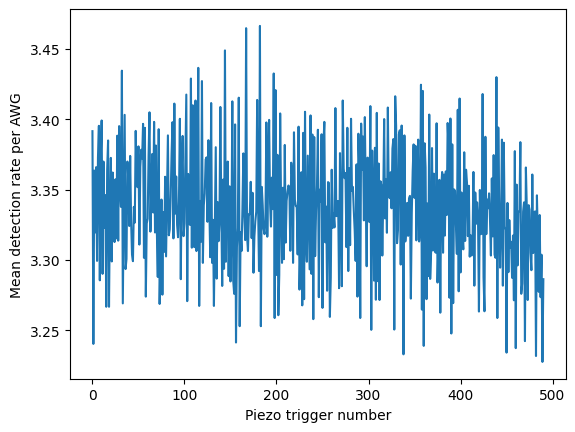

In [47]:
mean_det_list = []

for i in tqdm(range(len(timestamps_piezo_list))):
    total_det = 0
    time_bin_piezo_list = visnew.detection_binning(channels_piezo_list[i], timestamps_piezo_list[i], ch_AWG)

    for time in time_bin_piezo_list:
        total_det += len(time)
        mean_det = total_det/len(time_bin_piezo_list*25)
    mean_det_list.append(mean_det)

print("Mean detection rate = ", np.mean(mean_det_list))
plt.plot(mean_det_list)
plt.xlabel('Piezo trigger number')
plt.ylabel('Mean detection rate per AWG')


In [48]:
def get_interference_amplitude(count_total, bins, n_bins, integration_time, precision, plot=True, print_res=True):
    """
    Function to calculate the amplitude of the interference pattern in the time bin data.
    
    Parameters:
    time_bin_list: list of lists
        List of time bins with detections
    n_bins: int
        Number of bins in the histogram
    start_bin: int
        Start bin of integration time
    end_bin: int
        End bin of integration time
    integration_time: int
        Integration time in ps
    precision: float
        Precision of the peak finding algorithm
    plot: bool
        If True, plot the histogram
    print_res: bool
        If True, print the results
    
    Returns:
    count_total: array
        Array of counts in the histogram
    interference_amplitude: float
        Amplitude of the interference pattern
    
    
        """



    peaks, _ = find_peaks(count_total, height=max(count_total)/8, distance=4000)
    peaks = peaks.tolist()

    # Statement if peaks could not be detected. Note that the specified limit are specifically for n_bin = 2000

    if len(peaks) != 3:
        if len(peaks) == 2:
            # print('Warning: Number of peaks is 2')
            if peaks[0] > 2000:
                # print('Warning: Early peak not found')
                peaks.insert(0, 1700)
            if peaks[1] < 8000:
                # print('Warning: Late peak not found')
                peaks.append(11600)
            if peaks[0] < 2000 and peaks[1] > 8000:
                # print('Warning: Interference peak not found')
                peaks.insert(1, 6500)
            
        if len(peaks) == 1:
            # print('Warning: Number of peaks is 1')
            if peaks[0] > 2000 and peaks[0] < 8000:
                # print('Warning: Only interference peak found')
                peaks.insert(0, 1700)
                peaks.append(11600)
            if peaks[0] < 2000:
                # print('Warning: Only early peak found')
                peaks.append(6500)
                peaks.append(11600)
            if peaks[0] > 8000:
                # print('Warning: Only late peak found')
                peaks.insert(1, 6500)
                peaks.insert(0, 1700)

        if len(peaks) > 3:
            # print('Warning: Number of peaks is more than 3')
            peaks = peaks[:3]

    # Define regions for integration
    early_region = count_total[peaks[0]-int(n_bins*precision):peaks[0]+int(n_bins*precision)]
    late_region = count_total[peaks[2]-int(n_bins*precision):peaks[2]+int(n_bins*precision)]
    interference_region = count_total[peaks[1]-int(n_bins*precision):peaks[1]+int(n_bins*precision)]
    interference_amplitude = np.sum(interference_region)
    early_amplitude = np.sum(early_region)
    late_amplitude = np.sum(late_region)

    
    peaks_bin = [peaks[0], peaks[1], peaks[2]]
    # Convert peaks to time
    peaks = [bins[peaks[0]], bins[peaks[1]], bins[peaks[2]]]
    
    if print_res:
        print(f'Early peak at {peaks[0]}(bin {peaks_bin[0]}) with amplitude {early_amplitude}')
        print(f'Interference peak at {peaks[1]}(bin {peaks_bin[1]}) with amplitude {interference_amplitude}')
        print(f'Late peak at {peaks[2]}(bin {peaks_bin[2]}) with amplitude {late_amplitude}')




    if plot:
        plt.plot(bins[:-1], count_total)
        # plt.plot(count_total)
        
        plt.vlines(peaks[0]-int(n_bins*precision), colors='g', ymin=0, ymax=max(count_total))
        plt.vlines(peaks[0]+int(n_bins*precision), colors='g', ymin=0, ymax=max(count_total))
        plt.vlines(peaks[1]-int(n_bins*precision), colors='r', ymin=0, ymax=max(count_total))
        plt.vlines(peaks[1]+int(n_bins*precision), colors='r', ymin=0, ymax=max(count_total))
        plt.vlines(peaks[2]-int(n_bins*precision), colors='g', ymin=0, ymax=max(count_total))
        plt.vlines(peaks[2]+int(n_bins*precision), colors='g', ymin=0, ymax=max(count_total))

        plt.xlabel('Time [ps]')
        plt.ylabel('Number of detections')

        plt.title(f"Trident peaks for integration time {integration_time/10**9} ms")


    return interference_amplitude, early_amplitude, late_amplitude

In [49]:
def get_total_count_piezo(concatenated_time_bin, n_bins, num_pulses_per_AWG, integration_time, plot=True):
    """
    Function to get total detection events in time_bin_list.
    
    Parameters:
    time_bin_list: list of lists
        List of time bins with detections
    n_bins: int
        Number of bins in the histogram
    start_bin: int
        Start bin of integration time
    end_bin: int
        End bin of integration time
    integration_time: int
        Integration time in ps
    plot: bool
        If True, plot the histogram
    
    
    Returns:
    count_total: array
        Array of counts in the histogram

    
    
        """
    

    # Collect all tridents
    trident_list = []

    # concatenated_time_bin now contains all the detections in the integration time
    for i in range(num_pulses_per_AWG):
        clipped_time_bin = concatenated_time_bin[(concatenated_time_bin > pulse_separation*1000*i) & (concatenated_time_bin < pulse_separation*1000*(i+1))]
        trident_list.append(clipped_time_bin)

    count_list = []
    bin_list = []
    for i, trident in enumerate(trident_list):
        counts, bins = np.histogram(trident, bins=n_bins, range=(int(i*pulse_separation*1000), int((i+1)*pulse_separation*1000)))
        count_list.append(counts)
        bin_list.append(bins)

    count_total = 0
    for count in count_list:
        count_total += count




    if plot:
        plt.plot(bin_list[0][:-1], count_total)

        plt.xlabel('Time [ps]')
        plt.ylabel('Number of detections')

        plt.title(f"Trident peaks for integration time {integration_time/10**9} ms")


    return count_total, bin_list[0]

In [50]:
def display_oscillations(integration_time, time_frame, channels_piezo_list, timestamps_piezo_list, timetag, precision, save_img=True):

    window_list = []
    num_windows = int(total_num_piezos/2)

    for i in range(num_windows-1):
        
        channel1 = channels_piezo_list[2*i]
        channel2 = channels_piezo_list[2*i+1]
        timestamp1 = timestamps_piezo_list[2*i]
        timestamp2 = timestamps_piezo_list[2*i+1]

        channel_concat = np.concatenate((channel1, channel2))
        timestamp_concat = np.concatenate((timestamp1, timestamp2))


        window_list.append([channel_concat, timestamp_concat])
        

    time_bin_list_collection = []

    window_time = int(average_piezo_duration*2)
    num_integrations_per_window = int(window_time/integration_time)
    print('Number of integrations per window = ', num_integrations_per_window)

    num_windows_in_time_frame = int(time_frame/window_time)
    print('Number of windows in time frame = ', num_windows_in_time_frame)


    bin_size = int(integration_time/average_AWG_duration)
    print('Bin size = ', bin_size)

    for j in tqdm(range(num_integrations_per_window)):
        time_bin_list_collection.append([])
        for i in range(num_windows_in_time_frame):

            time_bin = visnew.detection_binning(window_list[i][0], window_list[i][1], ch_AWG, bin_size)[j]
            time_bin = time_bin[np.where(time_bin > 0)]
            time_bin_list_collection[j].append(time_bin)


    counts_for_all_integration_windows = []
    bins_for_all_integration_windows = []

    num_pulses_per_AWG = int(average_AWG_duration/(pulse_separation*1000))
    print('Number of pulses per AWG = ', num_pulses_per_AWG)

    for i in tqdm(range(num_integrations_per_window)):
        concat = np.concatenate(time_bin_list_collection[:][i])
        counts, bins = get_total_count_piezo(concat, n_bins, num_pulses_per_AWG, integration_time, plot=False)
        counts_for_all_integration_windows.append(counts)
        bins_for_all_integration_windows.append(bins)

    interference_amplitude_list = []
    early_amplitude_list = []
    late_amplitude_list = []

    for i in range(num_integrations_per_window):
        interference_amplitude, early_amplitude, late_amplitude = get_interference_amplitude(counts_for_all_integration_windows[i], bins_for_all_integration_windows[i], n_bins, integration_time, precision, plot=False, print_res=False)
        interference_amplitude_list.append(interference_amplitude)
        early_amplitude_list.append(early_amplitude)
        late_amplitude_list.append(late_amplitude)

    i, a, l = get_interference_amplitude(counts_for_all_integration_windows[0], bins_for_all_integration_windows[0], n_bins, integration_time, precision, plot=True, print_res=True)

    array = np.arange(0, num_integrations_per_window, 1)*(integration_time/10**9)/10**3


    fig, ax = plt.subplots(3, 1, figsize=(10, 10), sharex=True)
    ax[0].scatter(array, interference_amplitude_list)
    ax[0].set_ylabel('Interference amplitude')
    ax[0].set_title(f'Interference amplitude oscillations for integration time {integration_time/10**9} ms')
    ax[1].scatter(array, early_amplitude_list)
    ax[1].set_ylabel('Early amplitude')
    ax[1].set_title(f'Early amplitude oscillations for integration time {integration_time/10**9} ms')
    ax[2].scatter(array, late_amplitude_list)
    ax[2].set_ylabel('Late amplitude')
    ax[2].set_title(f'Late amplitude oscillations for integration time {integration_time/10**9} ms')
    ax[2].set_xlabel('Time [s]')

    if save_img:
            ms = integration_time/10**9
            before_ms, after_ms = str(ms).split('.')

            tf = time_frame/10**12
            before_tf, after_tf = str(tf).split('.')

            plt.savefig(os.getcwd() + os.sep + 'Images' + os.sep + f'raw_oscillations_{before_ms}_{after_ms}ms_tot_{before_tf}_{after_tf}_data_{timetag}.png')

    return interference_amplitude_list, early_amplitude_list, late_amplitude_list

In [51]:
def fit_sine_and_visibility(interference_amplitude_list, integration_time, time_frame, timetag, plot=True, save_img=True):

    time_array = np.arange(0, len(interference_amplitude_list), 1)*(integration_time/10**9)/10**3


    # Define the sine function
    def sine_func(x, amplitude, frequency, phase, setoff):
        return amplitude * np.sin(2 * np.pi * frequency * x + phase) + setoff 

    # Fit the sine function to the data
    x_data = time_array[:len(interference_amplitude_list)]
    y_data = interference_amplitude_list



    # Initial guess for the parameters
    initial_guess = [np.max(interference_amplitude_list), 100, 0, np.min(interference_amplitude_list)]

    # Perform the curve fit
    params, _ = curve_fit(sine_func, x_data, y_data, p0=initial_guess)

    # Extract the fitted parameters
    amplitude_fit, frequency_fit, phase_fit, setoff_fit = params

    if plot:
        # Print the fitted parameters
        print("Fitted Amplitude:", amplitude_fit)
        print("Fitted Frequency [Hz]:", frequency_fit)
        print("Fitted Phase:", phase_fit)

        plt.plot(x_data, y_data, 'o', label='data')
        plt.plot(x_data, sine_func(x_data, amplitude_fit, frequency_fit, phase_fit, setoff_fit), label='fit')
        plt.legend()
        plt.xlabel('Time [s]')
        plt.ylabel('Interference amplitude [a.u.]')
        plt.title(f'Sine fit for integration time {integration_time/10**9} ms')

        # Save the figure
        if save_img:
            ms = integration_time/10**9
            before_ms, after_ms = str(ms).split('.')

            tf = time_frame/10**12
            before_tf, after_tf = str(tf).split('.')
            plt.savefig(os.getcwd() + os.sep + 'Images' + os.sep + f'sine_fit_piezo_{before_ms}_{after_ms}ms_tot_{before_tf}_{after_tf}_data_{timetag}.png')

    fitted_interference_amplitude = sine_func(x_data, amplitude_fit, frequency_fit, phase_fit, setoff_fit)


    data_vis = (np.max(interference_amplitude_list) - np.min(interference_amplitude_list))/(np.max(interference_amplitude_list) + np.min(interference_amplitude_list))
    fit_vis = (np.max(fitted_interference_amplitude) - np.min(fitted_interference_amplitude))/(np.max(fitted_interference_amplitude) + np.min(fitted_interference_amplitude))

    print(f'Data visibility for time window {integration_time/10**9} ms = ', data_vis)
    print(f'Fitted visibility for time window {integration_time/10**9} ms = ', fit_vis)

    # Get first maximum of fitted sine function
    max_index = np.argmax(fitted_interference_amplitude)
    max_amp = fitted_interference_amplitude[max_index]

    return fitted_interference_amplitude, x_data, y_data, max_index, max_amp

Number of AWG triggers per piezo trigger =  5009
Number of integrations per window =  40
Number of windows in time frame =  49
Bin size =  250


  0%|          | 0/40 [00:00<?, ?it/s]

100%|██████████| 40/40 [00:11<00:00,  3.51it/s]


Number of pulses per AWG =  40


100%|██████████| 40/40 [00:00<00:00, 104.14it/s]


Early peak at 4347.7707(bin 1742) with amplitude 16099
Interference peak at 16971.78(bin 6800) with amplitude 9237
Late peak at 29343.70845(bin 11757) with amplitude 14386


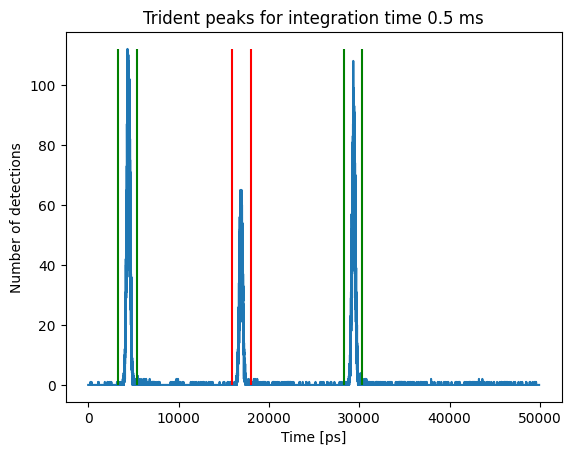

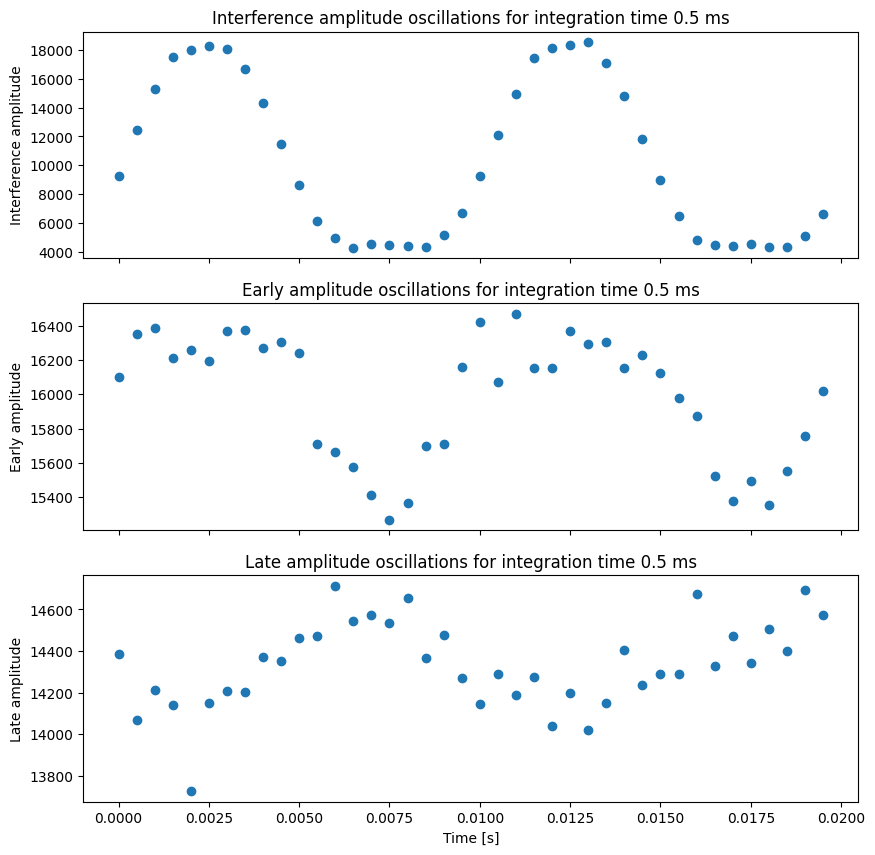

In [52]:
# Define parameters

integration_time = 500000000 # Integration time in ps, all detection events in one data point, determines the time resolution
time_frame = 1000000000000 # Time frame in ps
precision = 0.05

# Do not change without changing get_interference_amplitude function
binwidth = 100 # histogram bin width in ps
n_bins = int(2000000/binwidth)


num_AWG_per_piezo = len(times_AWG[np.where((times_AWG<=times_piezo[1]) & (times_AWG>=times_piezo[0]))])
print('Number of AWG triggers per piezo trigger = ', num_AWG_per_piezo)

interference_amplitude_list, early_amplitude_list, late_amplitude_list = display_oscillations(integration_time, time_frame, channels_piezo_list, timestamps_piezo_list, timetag, precision, save_img=True)


Fitted Amplitude: 7563.247070503892
Fitted Frequency [Hz]: 99.53213102194162
Fitted Phase: 0.056415616687804204
Data visibility for time window 0.5 ms =  0.625952860772803
Fitted visibility for time window 0.5 ms =  0.735669324482166


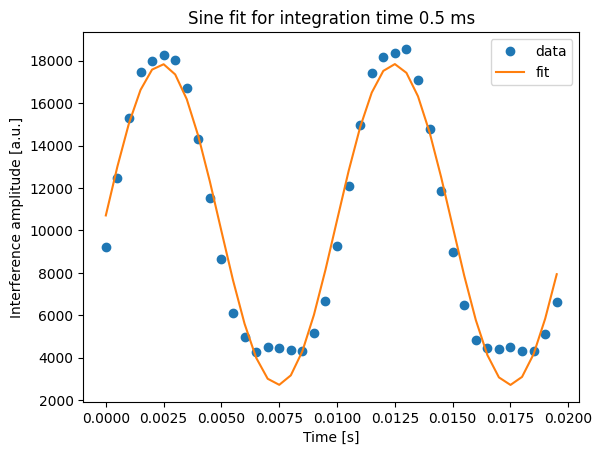

In [53]:
fitted_interference_amplitude, x_data, y_data, max_index, max_amp = fit_sine_and_visibility(np.array(interference_amplitude_list), integration_time, time_frame, timetag, plot=True, save_img=True)